# Tarea 2

Importamos las librerias necesarias

In [1]:
from astropy.io import fits
from scipy.optimize import curve_fit
from astropy.stats import sigma_clip
import matplotlib.pyplot as plt 
import numpy as np

Lectura del archivo FITS

In [2]:
#esta es una forma "automatizada" de obtener la velocidad(v) longitud(l) y latitud(b)
#esta funcion les entrega un arreglo con los valores reales del eje correspondiente
#1 es velocidad, 2 es longitud galactica, 3 es latitud galactica
def values(h,j):
    N=h['NAXIS'+str(j)];
    val=np.zeros(N);
    for i in range(0,N):
        val[i] = (i+1-float(h['CRPIX'+str(j)]))*float(h['CDELT'+str(j)]) + float(h['CRVAL'+str(j)]);
    return val;

cubo    = fits.open("cubo_de_datos.fits") #abrir objeto cubo de datos
data    = cubo[0].data #extraer matriz de datos
header  = cubo[0].header #extraer el header del archivo fits


#Estos seran los tres arreglos con los valores reales de los tres ejes del cubo
velocidad = values(header,1)
longitud  = values(header,2)
latitud = values(header,3)

print(latitud)

[-2.    -1.875 -1.75  -1.625 -1.5   -1.375 -1.25  -1.125 -1.    -0.875
 -0.75  -0.625 -0.5   -0.375 -0.25  -0.125  0.     0.125  0.25   0.375
  0.5    0.625  0.75   0.875  1.     1.125  1.25   1.375  1.5    1.625
  1.75   1.875  2.   ]


## Curva de rotacion

R0=8.5 kpc es la distancia radial del Sol al centro de la galaxia, l la longitud y ω(R) es la velocidad angular con respecto al centro de la galaxia V(R_0) es la velocidad del sol respecto al centro galáctico, el valor de esta constante, corresponde a 220[km/s]. La curva de rotacion se calcula con la siguiente expresion:

\begin{align}
V (R=R_0 sin(l)) =  \omega (R=R_0 sin(l)) \cdot R_0 · |sin(l)| 
\end{align}

Definimos los arreglos para vmin y bvmin, que irán guardando los valores que necesitamos. Tambien se fija el valor de las constantes

In [3]:
vmin=np.zeros(385)
vminalt = np.zeros(385)
bvmin=np.zeros(385)
bvminalt=np.zeros(385)

R0=8.5 #kPc
vsol=220 #km/s

Esta funcion a partir de una longitud, recorre la latitud y encuentra los valores de la velocidad terminal, guardandolos en un arreglo vs

In [4]:
def fmin(l, vs):
    #recorre latitud
    for q in range(33):
        T1=data[q][l][:]
        rms=np.sqrt(np.mean(T1**2))   #calcula rms
        #recorre velocidad
        for w in range(306):
            if data[q][l][w]>=5*rms:  #buscamos que no sea ruido
                vs[q]=velocidad[w]    #guardamos la primera v donde T mayor a 5rms
                break

Ahora aplicaremos la funcion a cada longitud, el valor y la latitud de la menor se guarda en vmin y vbmin

In [5]:
for l in range(385):
    vs=np.zeros(33)
    fmin(l, vs)
    indice = np.argmin(vs)
    vmin[l]=vs[indice]
    bvmin[l]=latitud[indice]

Procedimiento alternativo para obtener los arreglos vmin y bvmin

In [6]:
for l in range(len(longitud)):
    v_tan = np.zeros(len(latitud))
    for b in range(len(latitud)):
        T = data[b][l][:]
        r = sigma_clip(T, sigma_lower=5, sigma_upper=5, maxiters=1)
        rmask = r.mask
        if len(velocidad[rmask])==0:
            v_tan[b] = np.nan
        else:
            v_tan[b] = velocidad[rmask][0] 
    indice = np.nanargmin(v_tan)
    vminalt[l] = v_tan[indice]
    bvminalt[l] = latitud[indice]
        

Comparemos los resultados

In [7]:
diff = np.mean(abs(vmin-vminalt))
diff

2.202235844155844

Finalmente obtenemos los arreglos para vR, R y wR

In [8]:
vR = abs(vmin) + vsol*abs(np.sin(longitud*np.pi/180.))
R = abs(R0*np.sin(longitud*np.pi/180.))

vRalt = abs(vminalt) + vsol*abs(np.sin(longitud*np.pi/180.))

# velocidad angular
wR = vR/R

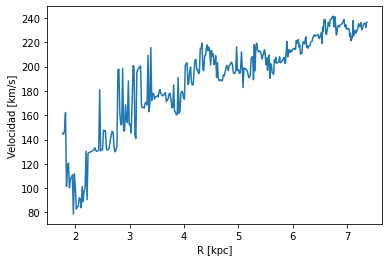

In [9]:
# Grafico vR vs R
plt.plot(R, vR)
plt.xlabel('R [kpc]')
plt.ylabel('Velocidad [km/s]')
plt.show()

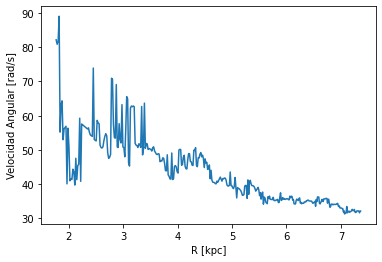

In [10]:
# Grafico v angular vs R
plt.plot(R, wR)
plt.xlabel('R [kpc]')
plt.ylabel('Velocidad Angular [rad/s]')
plt.show()

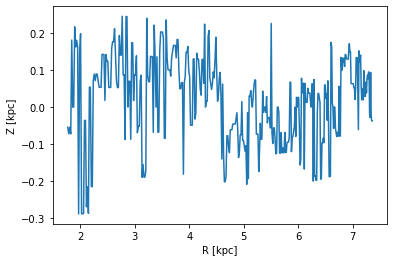

-0.2886583884626982


In [34]:
Z = bvmin*(np.pi/180)*R0*np.cos(longitud*np.pi/180)
plt.plot(R, Z)
plt.xlabel('R [kpc]')
plt.ylabel('Z [kpc]')
plt.show()

print(min(Z))

In [ ]:
## Modelos de distribución de masa para la curva de rotación


En la siguientes celdas veremos como ajustar un modelo de masa a la curva de rotación de la galaxia. Si asumimos que la galaxia tiene un perfil de masa M(r), entonces su velocidad será:

\begin{align}
v(r) =   \frac{GM(r)}{R}
\end{align}


Veremos el caso de una masa puntual $M_{0}$, para este caso tendremos que la velocidad puede expresarse en funcion del radio como:

\begin{align}
v(r) =   \frac{GM_{0}}{R}
\end{align}

Ajustaremos este modelo de distribucion de masa ocupando curve_fit de scipy

In [12]:
#definimos la constante G en unidades adecuadas
G=4.302e-6 # Units: kpc x M_sun^(-1) x (km/s)^2 

# funciones de velocidad para diferentes distribuciones de masa:

def masa(R,M0):
    M=M0
    v=np.sqrt(G*M/R)
    return v

def esfera_uniforme(R, rho):
    M = (4/3) * np.pi * (R**3) * rho
    v = np.sqrt(G*M/R)
    return v

def esfera_masa(R, M0, rho):
    M = (4/3) * np.pi * (R**3) * rho + M0
    v = np.sqrt(G*M/R)
    return v

def disco_uniforme(R, s):
    M = np.pi * (R**2) * s
    v = np.sqrt(G*M/R)
    return v

def disco_masa(R, M0, s):
    M = np.pi * (R**2) * s + M0
    v = np.sqrt(G*M/R)
    return v

Se realizan los ajustes correspondientes:

In [13]:
masa_p     , covmasa_p      = curve_fit(masa           ,R, vR, bounds=[0,10**20])
esfera_uni , covesfera_uni  = curve_fit(esfera_uniforme,R, vR, bounds=[0,10**20])
esfera_mas , covesfera_mas  = curve_fit(esfera_masa    ,R, vR, bounds=[0,10**20])
disco_uni  , covdisco_uni   = curve_fit(disco_uniforme ,R, vR, bounds=[0,10**20])
disco_mas  , covdisco_mas   = curve_fit(disco_masa     ,R, vR, bounds=[0,10**20])

Graficos

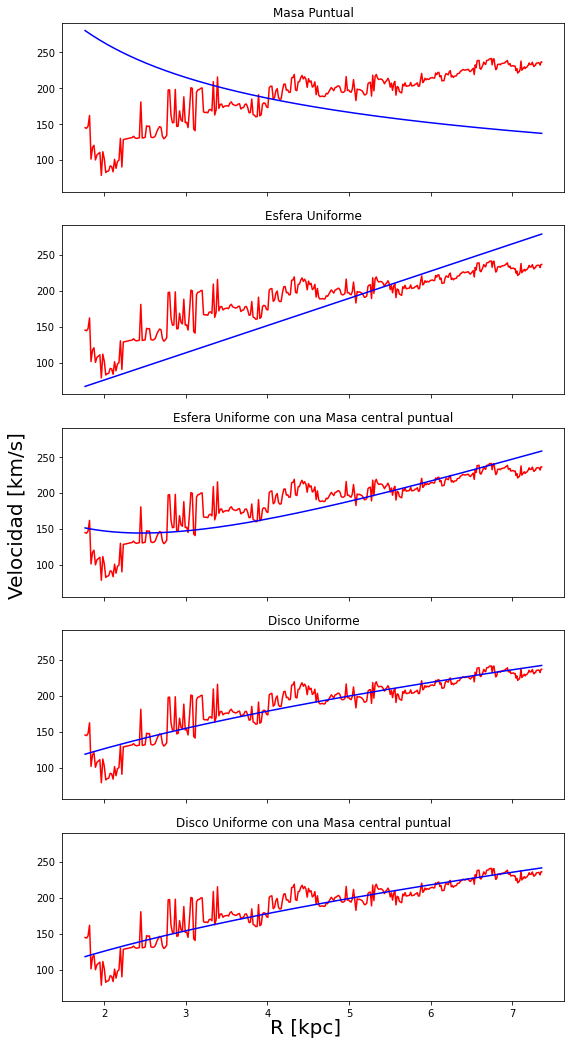

In [31]:
#Graficamos el ajuste
fig, axs = plt.subplots(5, 1, sharey=True, sharex=True, figsize=(9,18))

axs[0].plot(R, vR, 'r',label='Datos')
axs[0].plot(R, masa(R, masa_p[0]), 'b',label='Masa Puntual')
axs[0].set_title('Masa Puntual')

axs[1].plot(R, vR, 'r',label='Datos')
axs[1].plot(R, esfera_uniforme(R, esfera_uni[0]), 'b',label='Esfera Uniforme')
axs[1].set_title('Esfera Uniforme')

axs[2].plot(R, vR, 'r',label='datos')
axs[2].plot(R, esfera_masa(R, esfera_mas[0], esfera_mas[1]), 'b',label='Esfera + Masa Puntual')
axs[2].set_title('Esfera Uniforme con una Masa central puntual')

axs[3].plot(R, vR, 'r',label='datos')
axs[3].plot(R, disco_uniforme(R, disco_uni[0]), 'b',label='Disco Uniforme')
axs[3].set_title('Disco Uniforme')

axs[4].plot(R, vR, 'r',label='datos')
axs[4].plot(R, disco_masa(R, disco_mas[0], disco_mas[1]), 'b',label='Disco + Masa')
axs[4].set_title('Disco Uniforme con una Masa central puntual')

fig.text(0.5, 0.1, 'R [kpc]', ha='center', size=20)
fig.text(0.04, 0.5, 'Velocidad [km/s]', va='center', rotation='vertical', size=20)
plt.show()

El disco uniforme y el disco con masa puntual son los que mas se acercan a la curva de rotacion, para obtener una respuesta definitiva comparemos el error cuadrático medio entre estos dos modelos

In [29]:
duni = disco_uniforme(R, disco_uni[0])
dmas = disco_masa(R, disco_mas[0], disco_mas[1])
euni = esfera_uniforme(R, esfera_uni[0])
emas = esfera_masa(R, esfera_mas[0], esfera_mas[1])
mpun = masa(R, masa_p[0])

# calculo de la raiz del error cuadratico medio
error_duni = np.sqrt(sum((vR-duni)**2)/len(R))
error_dmasa = np.sqrt(sum((vR-dmas)**2)/len(R))
error_euni = np.sqrt(sum((vR-euni)**2)/len(R))
error_emasa = np.sqrt(sum((vR-emas)**2)/len(R))
error_mpun = np.sqrt(sum((vR-mpun)**2)/len(R))

51.56441746118722


In [16]:
print('disco uniforme:  ', error_duni)
print('disco masa:      ', error_dmasa)
print('esfera uniforme: ', error_euni)
print('esfera masa:     ', error_emasa)
print('masa puntual:    ', error_mpun)

disco uniforme:   14.783591622341358
disco masa:       14.783591623846958
esfera uniforme:  34.2488528710504
esfera masa:      21.8061715002011
masa puntual:     74.50489072994985


El error es menor en el modelo del disco de densidad uniforme con una masa puntual en su centro.

In [36]:
print('densidad del disco:   ', disco_uni[0])
print('masa galatica approx: ', np.pi * (16**2) * disco_uni[0])

densidad del disco:    [1.02465654e+01 5.88778172e+08]
masa galatica approx:  473523502550.06006
